In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import *
from scipy.optimize import minimize
from copy import deepcopy

In [3]:
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator
from qiskit.quantum_info import Pauli
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import random
from qiskit.compiler import transpile

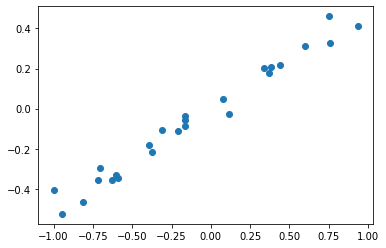

In [14]:
########  パラメータ  #############
## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 25
num_x_test = 25

## 学習したい1変数関数
func_to_learn = lambda x: 0.5*np.sin(x*np.pi)
func_to_learn1 = lambda x:np.abs(x) - 0.5
func_to_learn2 = lambda x:x*0.5

## 乱数のシード
random_seed = 1
## 乱数発生器の初期化
np.random.seed(random_seed)
### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn2(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise1 = 0.05
y_train = y_train + mag_noise1 * np.random.randn(num_x_train)

mag_noise2 = 0 #テストデータはノイズがないほうが過学習の影響がわかりやすい？
#テストデータの準備
x_test = x_min + (x_max - x_min) * np.random.rand(num_x_test)
y_test = func_to_learn2(x_test) + mag_noise2 * np.random.randn(num_x_test)

plt.plot(x_train, y_train, "o"); plt.show()

In [10]:
#ここでハミルトニアンを作り、使いまわす
pauli_list = []
nqubit = 2
evo_time = 10
# ΣaXに相当する部分をpauli_listに加える
for i in range(nqubit):
    a = random.uniform(-1,1)
    x = np.array([False if j != i else True for j in range(nqubit)],dtype=bool)
    z = np.array([False]*nqubit,dtype=bool)
    pauli_list.append([a,Pauli(z,x)])
# ΣJZZに相当する部分をpauli_listに加える
for i in range(nqubit):
    for k in range(i):
        J = random.uniform(-1,1)
        x = np.array([False]*nqubit,dtype=bool)
        z = np.array([True if (j == i or j == k) else False for j in range(nqubit)],dtype=bool)
        pauli_list.append([J,Pauli(z,x)])
qubitOp = WeightedPauliOperator(paulis=pauli_list)

In [8]:
def U_in(x):    #入力x、出力xをエンコードするゲートが付いた回路（QuantumCircuit）を返す
    U = QuantumCircuit(nqubit)
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    
    for i in range(nqubit):
        U.ry(angle_y,[i])
        U.rz(angle_z,[i])
    return U

In [11]:
def ansatz(init_par):  #入力パラメータ初期値のリスト、出力アンザッツが含まれた回路（QuantumCircuit）を返す
    U = QuantumCircuit(nqubit)
    U += qubitOp.evolve(
    U, evo_time, num_time_slices=1,
    expansion_mode='suzuki',
    expansion_order=3
)
    for i in range(nqubit):
        U.rx(init_par[i],i)
    
    return U

In [12]:
def qcl_pred(x,init_par):   #入力x、出力yの予測値
    qc = U_in(x)
    for i in range(depth):
        qc += ansatz(init_par[i*2:i*2 + 2])
    backend = Aer.get_backend("statevector_simulator")
    job = execute(qc,backend)
    counts = job.result().get_counts()
    res = 0
    for key in counts.keys():
        if key[-1] == "0":
            res += counts[key]
        else:
            res -= counts[key]
    return res
#counts[i]にしないとresは０にしかならない

In [7]:
def gene_error(par,loss):   #入力最適パラメータのリスト、出力汎化誤差
    res = 0
    for x,y in zip(x_test,y_test):
        res += loss(x,y,par)
    res /= float(len(x_train))
    return res

In [24]:
d = {}

In [27]:
#パラメータの初期値を乱数で設定し、コスト関数を最小化するパラメータを求める
#ここのfor文は初期パラメータを変更して学習することを何回繰り返すか、を決める
for i in range(1,2):
    depth = i
    for _ in range(1):
        init_par = [2*np.pi*np.random.rand() for _ in range(4*depth)]
        par = SGD(init_par,loss_func)
        d[depth] = d.get(depth,[]) + [(par,D_ast(par,loss_func),gene_error(par,loss_func),NIC(par,loss_func))]

print(d[depth])

[(array([1.76927762, 5.1339076 , 6.06101739, 4.88219846, 0.33905697,
       0.24748216]), 0.04207346213904972, 0.03226084305520557, 0.04207346213904972), (array([3.83552808, 2.86517674, 0.55661274, 2.18631282, 3.86055295,
       3.9440091 ]), 0.35426673229600475, 0.398851198818633, 0.3542667322960048)]


In [10]:
def loss_func(x,y,theta):
    #x:入力値、y:出力値、theta:学習後のパラメータベクトル
    return 0.5*((y-qcl_pred(x,theta))**2)

In [11]:
def shuffle(x,y):
    r = np.random.permutation(len(y))
    return x[r],y[r]

In [ ]:
def SGD(par,loss,lr=0.01,num_step=50,alpha=0.9):
    #lr:learning rate, par: parameter, loss: loss function
    #うまくいく時とうまくいかない時の差が激しい、何回か試す
    par = np.array(par)
    v = [0]*len(par)
    for _ in range(num_step):
        new_x,new_y = shuffle(x_train,y_train)
        for x,y in zip(new_x,new_y):
            for i in range(len(par)):
                v[i] =alpha*v[i] -lr*compute_gradient1(loss,x,y,par,i)
            for i in range(len(par)):
                par[i] =par[i] + v[i]
    return par

In [13]:
def compute_gradient1(loss,x,y,theta,num):
    #loss: 使うloss関数、x,y:i番目のデータ,theta:今のパラメータベクトル,num: 何番目のパラメータについて偏微分をとるか
    #出力は勾配ベクトル
    h = 1e-4
    theta1,theta2 = theta.copy(),theta.copy()
    theta1[num] += h
    theta2[num] -= h
    return (loss(x,y,theta1)-loss(x,y,theta2))/(2*h)

In [14]:
def compute_gradient2(loss,x,y,theta,num1,num2):
    h = 1e-4
    if num1 == num2:
        theta1,theta2 = theta.copy(),theta.copy()
        theta1[num1] += h
        theta2[num1] -= h
        return (loss(x,y,theta1) + loss(x,y,theta2) -2*loss(x,y,theta))/(h**2)
    else:
        theta1,theta2,theta3,theta4 = theta.copy(),theta.copy(),theta.copy(),theta.copy()
        theta1[num1],theta1[num2] = theta[num1]+h,theta[num2]+h
        theta2[num1],theta2[num2] = theta[num1]+h,theta[num2]-h
        theta3[num1],theta3[num2] = theta[num1]-h,theta[num2]+h
        theta4[num1],theta4[num2] = theta[num1]-h,theta[num2]-h
        return (loss(x,y,theta1) + loss(x,y,theta4) - loss(x,y,theta2) - loss(x,y,theta3))/(4*(h**2))

In [15]:
def G_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列G^ast
    n = len(par)
    G = np.array([[0 for _ in range(n)] for _ in range(n)])
    E_x = [0]*n    #E_x[i] = i番目の偏微分の期待値
    E_xy = [[0 for _ in range(n)] for _ in range(n)]  #E_xy[i][j] = i,j番目の偏微分の期待値
    for i in range(n):
        element = 0
        for x,y in zip(x_train,y_train):
            element += compute_gradient1(loss,x,y,par,i)
        element /= float(len(x_train))
        E_x[i] = element
        
    for i in range(n):
        for j in range(n):
            if i <= j:
                element = 0
                for x,y in zip(x_train,y_train):
                    element += compute_gradient1(loss,x,y,par,i)*compute_gradient1(loss,x,y,par,j)
                element /= float(len(x_train))
                E_xy[i][j] = element
            else:
                E_xy[i][j] = E_xy[j][i]
    
    for i in range(n):
        for j in range(n):
            G[i][j] = E_xy[i][j] - E_x[i]*E_x[j]
    return G

In [16]:
def Q_ast(par,loss):
    #入力:学習後のパラメータ、出力:行列Q^ast
    n = len(par)
    Q = np.array([[0 for _ in range(n)] for _ in range(n)])
    for i in range(n):
        for j in range(n):
            element = 0
            for x,y in zip(x_train,y_train):
                element += compute_gradient2(loss,x,y,par,i,j)
            element /= float(len(x_train))
            Q[i][j] = element
    return Q

In [17]:
def D_ast(par,loss):
    res = 0
    for x,y in zip(x_train,y_train):
        res += loss(x,y,par)
    res /= float(len(x_train))
    return res

In [18]:
def NIC(par,loss):
    f1 = D_ast(par,loss)
    G = G_ast(par,loss)
    Q = Q_ast(par,loss)
    Q_inv = np.linalg.pinv(Q)
    temp = np.dot(G,Q_inv)
    return f1 + np.trace(temp)/float(len(x_train))

In [28]:
depth = 2
par = [1.76927762, 5.1339076 , 6.06101739, 4.88219846, 0.33905697,
       0.24748216]

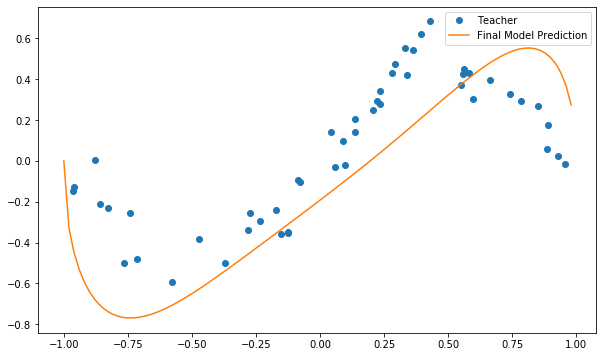

In [29]:
# プロットしたいときには以下を実行すればよい
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# モデルの予測値
y_pred = np.array([qcl_pred(x,par) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()